Copyright 2020 Natasha A. Sahr, Andrew M. Olney and made available under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0) for text and [Apache-2.0](http://www.apache.org/licenses/LICENSE-2.0) for code.


# Ridge and Lasso Regression: L1 and L2 penalization

## Regularization

Up to this point, we've focused on relatively small numbers of predictors in our models.
When we have datasets with large numbers of predictors, we need to think about new techniques to deal with the additional complexity.
Part of the reason is that our highly manual methods no longer scale well.
Imagine if you had to make and evaluate plots for 1000 variables!
The other part is that once we have many variables, the chances of them interacting with each other in very complicated ways gets increasingly larger.

We talked about one "bad" kind of interaction before, multicolinearity.
Multicolinearity occurs when two variables mostly measure the same thing.
The problem with multicolinearity in linear models is that the variables involved will no longer have unique solutions for their estimated coefficients.
What this means in practice is that multicolinearity is a small, but manageable problem for small datasets, but multicolinearity becomes a very serious problem for large datasets, at least for linear models, which arguably are the most important models in science.

Today we will talk about two methods that address the complexity of having many variables, including multicolinearity.
Both of these methods use a "big idea" in data science called **regularization**.
The idea behind regularization is that you **penalize** complex models in favor of simpler ones.
These simpler models use fewer variables, making them easier to understand.
If you penalization is set up in the right way, the simpler models can also avoid multicolinearity problems.
Today we will focus on ridge and lasso regression, but it is important to remember that many other models use similar regularization techniques. 
Once you know to look for it, you will start to see it everywhere!

## What you will learn

In the sections that follow, you will learn about ridge and lasso regularization and how they can help us assess a large number of variables in for candidacy in regression models by penalizing variables that don't contribute a large effect in the variability of the outcome. We will study the following:

- Ridge regression with the L2 penalty
- Lasso regression with the L1 penalty
- Assessing model accuracy
- Comparing regularized models 
- Selection of the tuning parameter $\lambda$

## When to use regularization/penalization in regression

Regularization is a general strategy that applies a penalty in the optimization of a regression model. With the correct tuning parameter selection, it will prevent overfitting a model to a particular dataset and improve the potential for generalization to new datasets.
Regularization becomes particularly important in regression where there are large numbers of predictors because it can mitigate multicollinearity and cause shrinkage (for L2) or encourage sparsity (for L1) of the coefficients for variables that contribute less to the prediction of the outcome.

## Vanilla logistic regression

Let's start by applying logistic regression to some breast cancer data.
This model will serve as a baseline for comparison to the ridge and lasso models that come later.
We're going to get the breast cancer data from `sklearn` instead of loading a CSV.
Libraries like `sklearn` frequently come with their own datasets for demonstration purposes.

### Load data

The [data](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset) consists of the following variables as mean, standard error, and "worst" (mean of three largest variables) collected by digital imagery of a biopsy.

| Variable | Type | Description |
|:-------|:-------|:-------|
|radius | Ratio | mean of distances from center to points on the perimeter|
|texture | Ratio | standard deviation of gray-scale values|
|perimeter | Ratio | perimeter of cancer|
|area | Ratio | area of cancer|
|smoothness | Ratio | local variation in radius lengths|
|compactness | Ratio |  perimeter^2 / area - 1.0|
|concavity | Ratio |  severity of concave portions of the contour|
|concave points | Ratio |  number of concave portions of the contour|
|symmetry | Ratio | symmetry of cancer|
|fractal dimension | Ratio | "coastline approximation" - 1|
| class | Nominal (binary) | malignant (1) or benign (0)

<div style="text-align:center;font-size: smaller">
    <b>Source:</b> This dataset was taken from the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI Machine Learning Repository library
    </a>
</div>
<br>

We want to predict the presence/absence of cancer, so it makes sense to use logistic regression rather than linear regression.
Ridge and lasso penalties work the same way in both kinds of regression.

First, import libraries for dataframes and to load the dataset: 

- `import pandas as pd`
- `import sklearn.datasets as datasets`

In [331]:
import pandas as pd
import sklearn.datasets as datasets

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="7]_oG^Y0XV,0(!d:E.}0">pd</variable><variable id="=l55S6$w5{IDU+4ID(5M">datasets</variable></variables><block type="importAs" id="MaTZ%BMEZU[L}(_VL)3f" x="51" y="48"><field name="libraryName">pandas</field><field name="VAR" id="7]_oG^Y0XV,0(!d:E.}0">pd</field><next><block type="importAs" id="PL5chXruGcet8N2(%vB@"><field name="libraryName">sklearn.datasets</field><field name="VAR" id="=l55S6$w5{IDU+4ID(5M">datasets</field></block></next></block></xml>

Next we need to do some conversion to put the `sklearn` data into a dataframe, which is the form we are most comfortable with:

- Set `cancer_sklearn` to with `datasets` do `load_breast_cancer` using

In [332]:
cancer_sklearn = datasets.load_breast_cancer()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable><variable id="=l55S6$w5{IDU+4ID(5M">datasets</variable></variables><block type="variables_set" id="Jy]Veqr#Nz^tri-F}]~|" x="50" y="210"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><value name="VALUE"><block type="varDoMethod" id="FK0hhKS}if`R/ncgG?)]"><mutation items="1"></mutation><field name="VAR" id="=l55S6$w5{IDU+4ID(5M">datasets</field><field name="MEMBER">load_breast_cancer</field><data>datasets:load_breast_cancer</data></block></value></block></xml>

The next step is to put this `sklearn` data into a dataframe:

- Set `dataframe` to with `pd` create `DataFrame` using
    - from `cancer_sklearn` get `data`
    - freestyle `columns=` followed by from `cancer_sklearn` get `feature_names`

In [333]:
dataframe = pd.DataFrame(cancer_sklearn.data,columns= (cancer_sklearn.feature_names))

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable><variable id="7]_oG^Y0XV,0(!d:E.}0">pd</variable><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable></variables><block type="variables_set" id="YU/U=`/lfca[(fK!1hxO" x="-161" y="55"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="VALUE"><block type="varCreateObject" id="T+/i49X#USsdbm*k`nxa"><mutation items="2"></mutation><field name="VAR" id="7]_oG^Y0XV,0(!d:E.}0">pd</field><field name="MEMBER">DataFrame</field><data>pd:DataFrame</data><value name="ADD0"><block type="varGetProperty" id="Qsp=@3(l6+c)8%1z11.]"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">data</field><data>cancer_sklearn:data</data></block></value><value name="ADD1"><block type="valueOutputCodeBlock" id="tB#*aU^#I@{4i0XtMKII"><field name="CODE">columns=</field><value name="INPUT"><block type="varGetProperty" id="`k[_0P%78p#4lOlE0[#]"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">feature_names</field><data>cancer_sklearn:feature_names</data></block></value></block></value></block></value></block><block type="variables_get" id="4Z;xB(G_5-i4iS=Xb*x_" x="-198" y="186"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></xml>

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


You can use this approach to put any `sklearn` format dataset into a dataframe.

Because this data is too "easy", we need to make it more complicated to really show the benefits of ridge and lasso.
Remember that multicolinearity is bad? 
Let's make it artificially multicolinear by duplicating the columns in the dataframe so that we have four side by side:

- Set `dataframe2` to `with pd do concat using`
    - A list containing
        - `dataframe` 
        - `dataframe` 
        - `dataframe` 
        - `dataframe` 
    - freestyle `axis=1`
    
The axis tells it to stack horizontally rather than vertically.

In [334]:
dataframe2 = pd.concat([dataframe, dataframe, dataframe, dataframe],axis=1)

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="l/|MYaqr|tQts3dHK)xR">dataframe2</variable><variable id="7]_oG^Y0XV,0(!d:E.}0">pd</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="]vh]^wib+-y5w|:rE#J9" x="-137" y="144"><field name="VAR" id="l/|MYaqr|tQts3dHK)xR">dataframe2</field><value name="VALUE"><block type="varDoMethod" id="!%IQTb.un+lZX^MwP2i8"><mutation items="2"></mutation><field name="VAR" id="7]_oG^Y0XV,0(!d:E.}0">pd</field><field name="MEMBER">concat</field><data>pd:concat</data><value name="ADD0"><block type="lists_create_with" id="Qx^Gikxw$RbMeQ;H{oN$"><mutation items="4"></mutation><value name="ADD0"><block type="variables_get" id="RD=FUdAz]XLmlWfxR`(y"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></value><value name="ADD1"><block type="variables_get" id="{2dPtzbB#a,/ol^4h@ai"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></value><value name="ADD2"><block type="variables_get" id="ypz[s%tkuWLq`_xHvHhd"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></value><value name="ADD3"><block type="variables_get" id="N}ugGH78B30tCdVGLZZZ"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></value></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="QJ2Lz~D7MZ3$Er3jEm-B"><field name="CODE">axis=1</field></block></value></block></value></block></xml>

Our duplicate columns have the same name, which will cause problems later.

To give them unique names, we can add the position of the column to the name:

- Set `colnames` to `list` for each item `i` in list
    - freestyle `enumerate(dataframe2.columns)`
    - yield `create text with`
        - in list `i` get `last`
        - "_"
        - in list `i` get `first`
- `colnames`

In [335]:
colnames = list((''.join([str(x) for x in [i[-1], '_', i[0]]])) for i in enumerate(dataframe2.columns))

colnames

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="]DdbMbUI~AxtU/Z^tdQV">colnames</variable><variable id="JyFQEY{zx}Tw4ylREDkF">i</variable></variables><block type="variables_set" id="S0IYph?Z}w%hZxa[0eLS" x="-278" y="-299"><field name="VAR" id="]DdbMbUI~AxtU/Z^tdQV">colnames</field><value name="VALUE"><block type="listBlock" id=";NrF[a19@NvA;dDT~0!I"><value name="x"><block type="comprehensionForEach" id="kd|%q(/3lgP|8X,F}H=O"><field name="VAR" id="JyFQEY{zx}Tw4ylREDkF">i</field><value name="LIST"><block type="dummyOutputCodeBlock" id="4I8z@BYm?o#Doc9!Fy%."><field name="CODE">enumerate(dataframe2.columns)</field></block></value><value name="YIELD"><block type="text_join" id=";h::-dKG)S@_4w.0Cv-n"><mutation items="3"></mutation><value name="ADD0"><block type="lists_getIndex" id="GT8u_ROncijDk32^)]Px"><mutation statement="false" at="false"></mutation><field name="MODE">GET</field><field name="WHERE">LAST</field><value name="VALUE"><block type="variables_get" id="vAqsa@KHeUjjGPChJT,O"><field name="VAR" id="JyFQEY{zx}Tw4ylREDkF">i</field></block></value></block></value><value name="ADD1"><block type="text" id="eY-$ni0n8g1HO,vO(u23"><field name="TEXT">_</field></block></value><value name="ADD2"><block type="lists_getIndex" id="|MUjO($5Eq*mdwncww-}"><mutation statement="false" at="false"></mutation><field name="MODE">GET</field><field name="WHERE">FIRST</field><value name="VALUE"><block type="variables_get" id="f-l(n:N%:@K-gs..F2sr"><field name="VAR" id="JyFQEY{zx}Tw4ylREDkF">i</field></block></value></block></value></block></value></block></value></block></value></block><block type="variables_get" id="k;vmK:x`ju^/}a9u++,@" x="-270" y="-106"><field name="VAR" id="]DdbMbUI~AxtU/Z^tdQV">colnames</field></block></xml>

['mean radius_0',
 'mean texture_1',
 'mean perimeter_2',
 'mean area_3',
 'mean smoothness_4',
 'mean compactness_5',
 'mean concavity_6',
 'mean concave points_7',
 'mean symmetry_8',
 'mean fractal dimension_9',
 'radius error_10',
 'texture error_11',
 'perimeter error_12',
 'area error_13',
 'smoothness error_14',
 'compactness error_15',
 'concavity error_16',
 'concave points error_17',
 'symmetry error_18',
 'fractal dimension error_19',
 'worst radius_20',
 'worst texture_21',
 'worst perimeter_22',
 'worst area_23',
 'worst smoothness_24',
 'worst compactness_25',
 'worst concavity_26',
 'worst concave points_27',
 'worst symmetry_28',
 'worst fractal dimension_29',
 'mean radius_30',
 'mean texture_31',
 'mean perimeter_32',
 'mean area_33',
 'mean smoothness_34',
 'mean compactness_35',
 'mean concavity_36',
 'mean concave points_37',
 'mean symmetry_38',
 'mean fractal dimension_39',
 'radius error_40',
 'texture error_41',
 'perimeter error_42',
 'area error_43',
 'smooth

As you can see, we're now working with 120 predictor variables instead of the original 30.
It's a lot more than we'd like to have to examine manually. 

`sklearn` stores the predictors and the target (outcome) variable separately, so we need to `assign` it to the dataframe:

- Freestyle `dataframe2.columns = colnames`
- Set `dataframe` to with `dataframe2` do `assign` using
    - freestyle `Target=` followed by from `cancer_sklearn` get `target`
- `dataframe` (to display)

In [336]:
dataframe2.columns = colnames

dataframe = dataframe2.assign(Target= (cancer_sklearn.target))

dataframe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable><variable id="l/|MYaqr|tQts3dHK)xR">dataframe2</variable><variable id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</variable></variables><block type="dummyOutputCodeBlock" id=".1afw^qVP9)%pbb.Cds#" x="-532" y="-110"><field name="CODE">dataframe2.columns = colnames</field></block><block type="variables_set" id="3Ze8f[aXmPfl;vaA$Rk:" x="-553" y="-45"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="VALUE"><block type="varDoMethod" id="},@=kiIyC;D?%w.dwTPl"><mutation items="1"></mutation><field name="VAR" id="l/|MYaqr|tQts3dHK)xR">dataframe2</field><field name="MEMBER">assign</field><data>dataframe2:assign</data><value name="ADD0"><block type="valueOutputCodeBlock" id="7p8-=K$PBCtmko8/z3,O"><field name="CODE">Target=</field><value name="INPUT"><block type="varGetProperty" id="!XPjc8KOR75aM?`-W,0m"><field name="VAR" id="etU=(k#nJyVsPHL@^Jv.">cancer_sklearn</field><field name="MEMBER">target</field><data>cancer_sklearn:target</data></block></value></block></value></block></value></block><block type="variables_get" id="vgsGY[H5n%MhI8[*;Un~" x="-442" y="40"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field></block></xml>

,mean radius_0,mean texture_1,mean perimeter_2,mean area_3,mean smoothness_4,mean compactness_5,mean concavity_6,mean concave points_7,mean symmetry_8,mean fractal dimension_9,...,worst texture_111,worst perimeter_112,worst area_113,worst smoothness_114,worst compactness_115,worst concavity_116,worst concave points_117,worst symmetry_118,worst fractal dimension_119,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


### Explore data

Based on the earlier discussion, you might guess that this dataset has a problem with multicolinearity.
And you'd be right!

Let's make a quick heatmap to show this:

- `import plotly.express as px`

In [337]:
import plotly.express as px

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="+yh,Zg{hON]zy6D~.rH#">px</variable></variables><block type="importAs" id="JKd}DIrGfV*IelKZ!4ls" x="-199" y="-10"><field name="libraryName">plotly.express</field><field name="VAR" id="+yh,Zg{hON]zy6D~.rH#">px</field></block></xml>

And now a "one line" heatmap:

- with `px` do `imshow` using
    - `with dataframe do corr using`
    - A freestyle block **with a notch on the right** containing `x=`, connected to `from dataframe get columns`
    - A freestyle block **with a notch on the right** containing `y=`, connected to `from dataframe get columns`

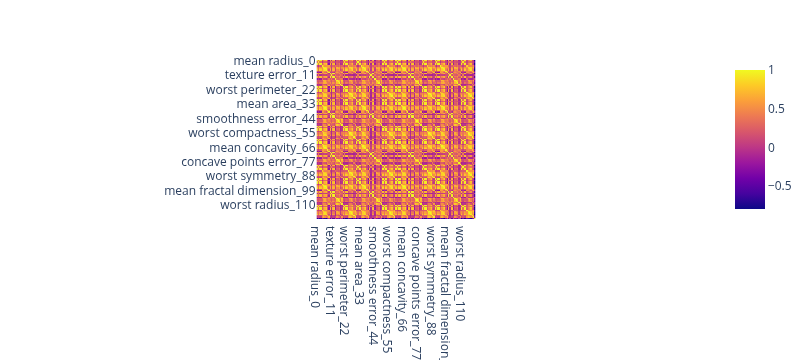

In [338]:
px.imshow(dataframe.corr(),x= (dataframe.columns),y= (dataframe.columns))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="+yh,Zg{hON]zy6D~.rH#">px</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="varDoMethod" id="7PkTI5@+A6#C}J7CTmyF" x="-289" y="-8"><mutation items="3"></mutation><field name="VAR" id="+yh,Zg{hON]zy6D~.rH#">px</field><field name="MEMBER">imshow</field><data>px:imshow</data><value name="ADD0"><block type="varDoMethod" id="zQlnf1:H{S[lwx.=oh4e"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">corr</field><data>dataframe:corr</data></block></value><value name="ADD1"><block type="valueOutputCodeBlock" id="w@8=b/l5s88(Q5J[WUES"><field name="CODE">x=</field><value name="INPUT"><block type="varGetProperty" id="tYGU^y~o=au;-zDk`!;-"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">columns</field><data>dataframe:columns</data></block></value></block></value><value name="ADD2"><block type="valueOutputCodeBlock" id="8EA2+)nDoNVWEkWz$;~I"><field name="CODE">y=</field><value name="INPUT"><block type="varGetProperty" id="q`v83u2ne+l=1:nC@|BN"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">columns</field><data>dataframe:columns</data></block></value></block></value></block></xml>

Our data is plaid!
It's plaid because we repeated it four times, and you can see this repetition in the heatmap.

Anything light orange to yellow could give us positive colinearity problems, and anything dark purple to indigo could give us negative colinearity problems.

Depending on the size of your screen, `plotly` may only show every second or third variable name.
You can use the Zoom tool to explore this correlation matrix more closely.

## Prepare train/test sets

We need to split the dataframe into `X`, our predictors, and `Y`, our target variable (breast cancer positive).

Do the imports for splitting:

- `import sklearn.model_selection as model_selection`

In [339]:
import sklearn.model_selection as model_selection

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="uASGz64Zb$AOvQyV4pRj">model_selection</variable></variables><block type="importAs" id="sN1YO5FEzpHyxb31@j,Z" x="16" y="10"><field name="libraryName">sklearn.model_selection</field><field name="VAR" id="uASGz64Zb$AOvQyV4pRj">model_selection</field></block></xml>

Create `X` by dropping the label from the dataframe:

- Set `X` to with `dataframe` do `drop` using
    - freestyle `columns=["Target"]`
- `X` (to display)

In [340]:
X = dataframe.drop(columns= ['Target'])

X

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Eu6+HM0^Zfw6=$49Xgk7">X</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="bzZTS1@$}n#~vk7l2~9!" x="-320" y="-124"><field name="VAR" id="Eu6+HM0^Zfw6=$49Xgk7">X</field><value name="VALUE"><block type="varDoMethod" id="W{$DG6fLq}9XMB;w~tpR"><mutation items="1"></mutation><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">drop</field><data>dataframe:drop</data><value name="ADD0"><block type="valueOutputCodeBlock" id="=Seu,Dq?hm}di4wJM|?h"><field name="CODE">columns=</field><value name="INPUT"><block type="lists_create_with" id="s6ve9uG:vPaKHMD8,3S("><mutation items="1"></mutation><value name="ADD0"><block type="text" id="NZ#xE^.auc?IrjY~,j6,"><field name="TEXT">Target</field></block></value></block></value></block></value></block></value></block><block type="variables_get" id="$l-j^o#3[L+Ba4W%G6S;" x="-300" y="-9"><field name="VAR" id="Eu6+HM0^Zfw6=$49Xgk7">X</field></block></xml>

,mean radius_0,mean texture_1,mean perimeter_2,mean area_3,mean smoothness_4,mean compactness_5,mean concavity_6,mean concave points_7,mean symmetry_8,mean fractal dimension_9,...,worst radius_110,worst texture_111,worst perimeter_112,worst area_113,worst smoothness_114,worst compactness_115,worst concavity_116,worst concave points_117,worst symmetry_118,worst fractal dimension_119
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Create `Y` by pulling just `Target` from the dataframe:

- Set `Y`to `dataframe [ ] ` containing the following in a list
    - `"Target"`
- `Y` (to display)

In [341]:
Y = dataframe[['Target']]

Y

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="vEy06PN?Djk]8Ag?;UWi">Y</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="variables_set" id="mu*+:7,;wUl/G3WC?~[1" x="-35" y="-149"><field name="VAR" id="vEy06PN?Djk]8Ag?;UWi">Y</field><value name="VALUE"><block type="indexer" id="3,DFaMh*a07B/[#{pcY#"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><value name="INDEX"><block type="lists_create_with" id="7CG2MkS#du1xOH_Ca3ZR"><mutation items="1"></mutation><value name="ADD0"><block type="text" id=")5H0~!;RVY0z=POYKKEh"><field name="TEXT">Target</field></block></value></block></value></block></value></block><block type="variables_get" id="+vIBq7Hk4e_Nd9CY4*sL" x="-25" y="-76"><field name="VAR" id="vEy06PN?Djk]8Ag?;UWi">Y</field></block></xml>

,Target
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0


Now do the splits:

- Set `splits` to with `model_selection` do `train_test_split` using
    - `X`
    - `Y`
    - freestyle `random_state=2` (this will make your random split the same as mine)
    
**Notice we did not specify a test size; `sklearn` will use .25 by default**.

In [342]:
splits = model_selection.train_test_split(X,Y,random_state=2)
print(splits[3])

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable><variable id="uASGz64Zb$AOvQyV4pRj">model_selection</variable><variable id="Eu6+HM0^Zfw6=$49Xgk7">X</variable><variable id="vEy06PN?Djk]8Ag?;UWi">Y</variable></variables><block type="variables_set" id="oTGRJ#{R!U^we@Bl@pkT" x="-26" y="41"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field><value name="VALUE"><block type="varDoMethod" id="f?j@ker(a#hJv;Nh)IGX"><mutation items="3"></mutation><field name="VAR" id="uASGz64Zb$AOvQyV4pRj">model_selection</field><field name="MEMBER">train_test_split</field><data>model_selection:train_test_split</data><value name="ADD0"><block type="variables_get" id="LUWIUAuJ*|qhDZv9V]^K"><field name="VAR" id="Eu6+HM0^Zfw6=$49Xgk7">X</field></block></value><value name="ADD1"><block type="variables_get" id="mM/{xeAht^dQ4_RKkRvn"><field name="VAR" id="vEy06PN?Djk]8Ag?;UWi">Y</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="PDBbqt0iT:z][oy_|6Xn"><field name="CODE">random_state=2</field></block></value></block></value><next><block type="text_print" id="xjkwVln~Gckfl)7zs4Xa"><value name="TEXT"><block type="lists_getIndex" id="Tx{!825{,%WK0us*owI`"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="fbPG@JqOJ@~U|Tao#)an"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="zre14}]pW0i9VxIa4{S8"><field name="NUM">4</field></block></value></block></value></block></next></block></xml>

     Target
528       1
291       1
467       1
108       0
340       1
..      ...
76        1
322       1
173       1
470       1
526       1

[143 rows x 1 columns]


### Model 1: Logistic regression

Let's do something we already suspect is not a great idea: regular logistic regression.

First, the imports for regression, evaluation, preprocessing, and pipelines:

- `import sklearn.linear_model as linear_model`
- `import sklearn.metrics as metrics`
- `import numpy as np`
- `import sklearn.preprocessing as pp`
- `import sklearn.pipeline as pipe`

In [343]:
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import numpy as np
import sklearn.preprocessing as pp
import sklearn.pipeline as pipe

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable></variables><block type="importAs" id="C,|uKYZ4CH*/,cD|4($8" x="135" y="303"><field name="libraryName">sklearn.linear_model</field><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><next><block type="importAs" id="*G_SVgZ;}hIr,Hi1~$Z6"><field name="libraryName">sklearn.metrics</field><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><next><block type="importAs" id="8;{*.D?hUhOnD8:R9Vfr"><field name="libraryName">numpy</field><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><next><block type="importAs" id="/YAkt4vqDQp/.5;pPcY."><field name="libraryName">sklearn.preprocessing</field><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><next><block type="importAs" id="O15G]dI#1oM;`7^r@Pr,"><field name="libraryName">sklearn.pipeline</field><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field></block></next></block></next></block></next></block></next></block></xml>

#### Training

We're going to make a pipeline so we can scale and train in one step:

- Set `std_clf` to with `pipe` do `make_pipeline` using
    - with `pp` create `StandardScaler` using
    - with `linear_model` create `LogisticRegression` using
        - freestyle `penalty=None`

**The "none" penalty here is important because `sklearn` uses a ridge penalty by default.**

In [344]:
std_clf = pipe.make_pipeline(pp.StandardScaler(),linear_model.LogisticRegression(penalty=None))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`P)`+jl|;h{.[r}{78q6">std_clf</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="}81D/tZY#o}$E:M}:u4x" x="-103" y="30"><field name="VAR" id="`P)`+jl|;h{.[r}{78q6">std_clf</field><value name="VALUE"><block type="varDoMethod" id="(Noh/e~gvTM3-4|;g]s["><mutation items="2"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">make_pipeline</field><data>pipe:make_pipeline</data><value name="ADD0"><block type="varCreateObject" id="wdBBmRU@5zc/9@i]kvG1"><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value><value name="ADD1"><block type="varCreateObject" id="mrDnOKmr{E_(mobz.MzL"><mutation items="1"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="8M)Z?G;,TAHBD5A|#Ecz"><field name="CODE">penalty=None</field></block></value></block></value></block></value></block></xml>

We can treat the whole pipeline as a classifier and call `fit` on it:

-  with `std_clf` do `fit using`
    - in list `splits` get # `1` (this is Xtrain)
    - with `np` do `ravel` using
        - in list `splits` get # `3` (this is Ytrain)

In [345]:
std_clf.fit(splits[0],np.ravel(splits[2]))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="`P)`+jl|;h{.[r}{78q6">std_clf</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="varDoMethod" id="Z)$q-zn.KTC{+^l-wH6u" x="170" y="-60"><mutation items="2"></mutation><field name="VAR" id="`P)`+jl|;h{.[r}{78q6">std_clf</field><field name="MEMBER">fit</field><data>std_clf:fit</data><value name="ADD0"><block type="lists_getIndex" id="%ZP;TzwqTCykCe1Gvv0."><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="jwgs7jMPK!(6EGNs,6.j"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="[4AixI#E/fO28i!Ap(XH"><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="aq:u45XRC=v1nMWs;Kaf"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id="!n@qb@~@Ye9+NI9M3$RI"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="]7?P*n5]OMOQfk9]4uDW"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id=".kNWS$um@~2vFVZ)l^j$"><field name="NUM">3</field></block></value></block></value></block></value></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(penalty=None))])

Now we can get predictions from the model for our test data:

- Set `predictions` to with `std_clf` do `predict` using
    - in list `splits` get # `2` (this is Xtest)
- `predictions` (to display)

In [346]:
predictions = std_clf.predict(splits[1])

predictions

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable><variable id="`P)`+jl|;h{.[r}{78q6">std_clf</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="variables_set" id="NHw$/HH988vNLbZgn)CM" x="53" y="43"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field><value name="VALUE"><block type="varDoMethod" id="N}3ds6:i%0MtTA:(2im4"><mutation items="1"></mutation><field name="VAR" id="`P)`+jl|;h{.[r}{78q6">std_clf</field><field name="MEMBER">predict</field><data>std_clf:predict</data><value name="ADD0"><block type="lists_getIndex" id="T;%r4RIlNhw2Y}@KJQGR"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="d`ea-E55KplK,k;I?Y^j"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id=".w0Q$u#?]DMn]T|X;V*W"><field name="NUM">2</field></block></value></block></value></block></value></block><block type="variables_get" id="S=7vAP(d1+wS1dBe#0%v" x="121" y="166"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field></block></xml>

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluation

To get the accuracy:

- `print` `create text with`
    - "Accuracy:"
    - with `metrics` do `accuracy_score` using
        - in list `splits` get # `4`  (this is `Ytest`)
        - `predictions`

In [347]:
print('Accuracy:' + str(metrics.accuracy_score(splits[3],predictions)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="6KCf/4(JectOv*aO[L6d" x="43" y="40"><value name="TEXT"><block type="text_join" id="|l|?2Yb#{m=ys_V^)+v-"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="8MdDU0D^rCAqKltb#kaY"><field name="TEXT">Accuracy:</field></block></value><value name="ADD1"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="lists_getIndex" id="!Es0(8pKn4L4Sf;%UL43"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="OILVf3jh`XN;saK_CnV?"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="6@+i-@CZM9Gmj8+p_FuA"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="v{o)9415e|as*lbvf|/k"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field></block></value></block></value></block></value></block></xml>

Accuracy:0.9230769230769231


To get precision, recall, and F1:

- `print` with `metrics` do `classification_report` using
    - in list `splits` get # `4`  (this is `Ytest`)
    - `predictions`

In [348]:
print(metrics.classification_report(splits[3],predictions))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="(`;mrW|63Vww]$wlV9+1">predictions</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="w?Z]Mpw]G,uTA;S:C5Ef" x="46" y="38"><value name="TEXT"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="lists_getIndex" id="^SU2NkM2W=TDM8*r2:;F"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="c1|tZp[}5_#u^`bd/mCz"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="r(l-:8|vdoebs:z-ff1r"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id=":ut`YN=Re@{%Kr)(ArD0"><field name="VAR" id="(`;mrW|63Vww]$wlV9+1">predictions</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        56
           1       0.97      0.90      0.93        87

    accuracy                           0.92       143
   macro avg       0.92      0.93      0.92       143
weighted avg       0.93      0.92      0.92       143



## Regression with a Ridge (L2) Penalty

In ridge regression, also known as L2 penalization, the cost function is altered by adding a penalty equivalent to the square of the magnitude of the coefficients. This is equivalent to saying: for some $c > 0$, $\sum_{j=0}^p \beta_j^2 < 0$ for coefficients $\beta_j, j=1,\dots,p$. 

The cost function for ridge regression is

$$\sum_{i=1}^N (y_i-\hat{y_i})^2 = \sum_{i=1}^N (y_i - \sum_{j=0}^p \beta_i x_{ij})^2 + \lambda \sum_{j=0}^p \beta_j^2$$

When $\lambda = 0$, we have is a linear regression model.

The $\lambda$ regularizes the coefficients so the optimization function is penalized if the coefficients are large. This type of penalization leads to coefficients close to, but not exactly, zero. This feature of ridge regression shrinks the coefficients allowing for a reduction of model complexity and multicollinearity.

### Model 2: Logistic ridge regression (C=.75)

Adding a ridge penalty is almost *exactly* like the model we did before.
There are two differences:

- penalty="l2"
- C = .75

The ridge penalty is an l2 penalty (because it's squared).
The `C` value is the **amount** of the penalty.
In `sklearn` it is inverted, so smaller numbers mean more penalty.

**Do yourself a favor and copy the blocks you've already done. You can save your notebook, right click it in the file browser, select "Duplicate", and then open that copy in 3 pane view by dragging the tab to the center right. Make sure you change variable names as directed.**

**Here's how to duplicate:**

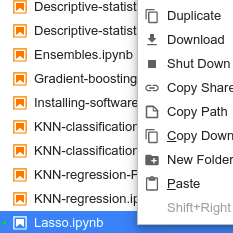

**Here's 3 pane view:**

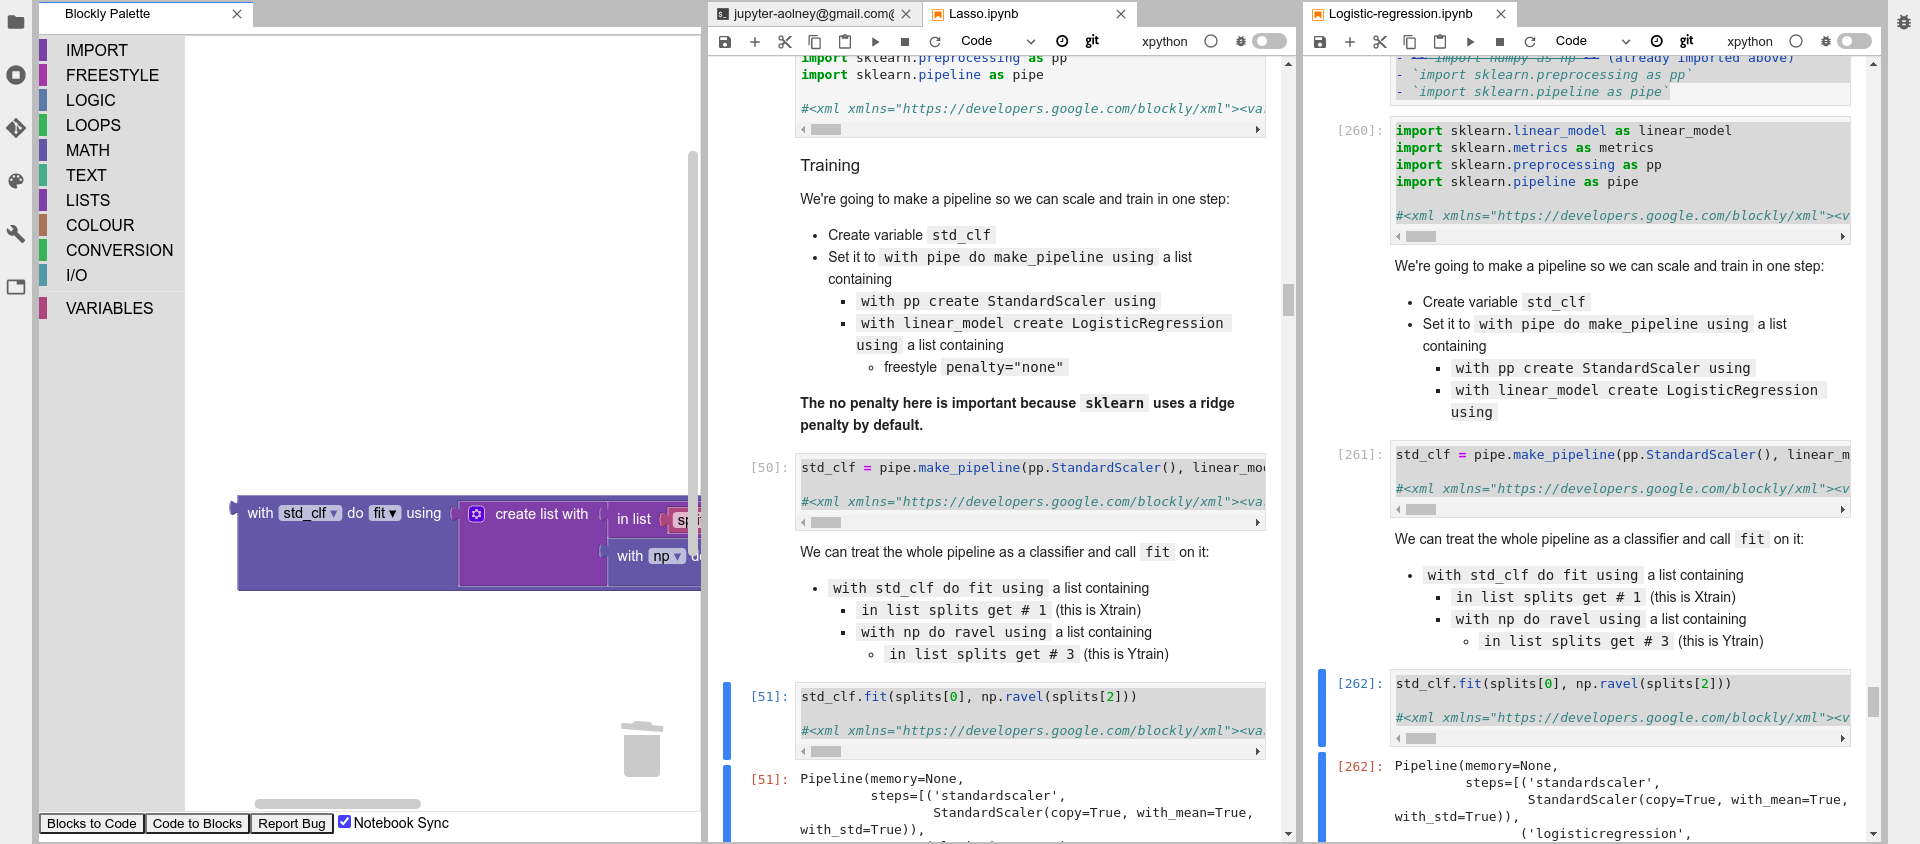

#### Training

- Set `std_clf_ridge75` to with `pipe` do `make_pipeline` using
    - with `pp` create `StandardScaler` using
    - with `linear_model` create `LogisticRegression using` 
        - freestyle `penalty="l2"`
        - freestyle `C=0.75`

In [349]:
std_clf_ridge75 = pipe.make_pipeline(pp.StandardScaler(),linear_model.LogisticRegression(penalty="l2",C=0.75))

std_clf_ridge75

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="}81D/tZY#o}$E:M}:u4x" x="0" y="0"><field name="VAR" id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</field><value name="VALUE"><block type="varDoMethod" id="(Noh/e~gvTM3-4|;g]s["><mutation items="2"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">make_pipeline</field><data>pipe:make_pipeline</data><value name="ADD0"><block type="varCreateObject" id="6$,n_gmVE@WC*:bauJ`R"><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value><value name="ADD1"><block type="varCreateObject" id="N`lud_XvYJH_fDv$Ybm#"><mutation items="2"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="_/|b8:!#[1L6KA,RP3Ld"><field name="CODE">penalty="l2"</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="8Dd6-?TF%rNs6Fs7UI,:"><field name="CODE">C=0.75</field></block></value></block></value></block></value></block><block type="variables_get" id="7sbKLLQyo^Qks(`:7,YL" x="230" y="241"><field name="VAR" id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</field></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.75))])

We can treat the whole pipeline as a classifier and call `fit` on it:

-  with `std_clf_ridge75` do `fit` using
    - in list `splits` get # `1` (this is Xtrain)
    - with `np` do `ravel` using
        - in list `splits` get # `3` (this is Ytrain)

In [350]:
std_clf_ridge75.fit(splits[0],np.ravel(splits[2]))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="varDoMethod" id="Z)$q-zn.KTC{+^l-wH6u" x="17" y="-36"><mutation items="2"></mutation><field name="VAR" id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</field><field name="MEMBER">fit</field><data>std_clf_ridge75:fit</data><value name="ADD0"><block type="lists_getIndex" id="i$8Y)P)$kC5`UI/hH3;|"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="3;UNlsPDZ$:T!S7h(ZS("><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="D`itZhMJ.cz)0pC$ZZ:H"><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="V(hWX{k0ulfKk2kEmQZ%"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id="cYIjf#}.!|.@3nf4Zbro"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="3J.c/~Eq$Q;T}y4ghuN,"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="Ze[@JGpgSrj]my-6a.e}"><field name="NUM">3</field></block></value></block></value></block></value></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.75))])

Now we can get predictions from the model for our test data:

- Set `predictions_ridge75` to with `std_clf_ridge75` do `predict` using
    - in list `splits` get # `2` (this is Xtest)

In [351]:
predictions_ridge75 = std_clf_ridge75.predict(splits[1])

predictions_ridge75

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</variable><variable id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="variables_set" id="NHw$/HH988vNLbZgn)CM" x="0" y="0"><field name="VAR" id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</field><value name="VALUE"><block type="varDoMethod" id="N}3ds6:i%0MtTA:(2im4"><mutation items="1"></mutation><field name="VAR" id="mA/9BG{!(La}o`*JeNUP">std_clf_ridge75</field><field name="MEMBER">predict</field><data>std_clf_ridge75:predict</data><value name="ADD0"><block type="lists_getIndex" id="LPH2}[[0+Ob~)cl3HBji"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="RWyVE$qMYc28[N]^:*V9"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="#}Y`S!iK_SecsV^JBwAL"><field name="NUM">2</field></block></value></block></value></block></value></block><block type="variables_get" id="g{BXbAh8SGlz~iGHL%Kw" x="19" y="101"><field name="VAR" id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</field></block></xml>

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluation

To get the accuracy:

- `print` `create text with`
    - "Accuracy:"
    - with `metrics` do `accuracy_score` using
        - in list `splits` get # `4`  (this is `Ytest`)
        - `predictions_ridge75`

In [352]:
print('Accuracy:' + str(metrics.accuracy_score(splits[3],predictions_ridge75)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="6KCf/4(JectOv*aO[L6d" x="40" y="42"><value name="TEXT"><block type="text_join" id="|l|?2Yb#{m=ys_V^)+v-"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="8MdDU0D^rCAqKltb#kaY"><field name="TEXT">Accuracy:</field></block></value><value name="ADD1"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="lists_getIndex" id="ShBH6^MsT)?B;Gy(Ma@o"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="|{/%E1nF5~GXgu|ZviAX"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="pqz`QJH,3AoY/_n)_tag"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="lfXwo4{Yg3*K8A3F#2gY"><field name="VAR" id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</field></block></value></block></value></block></value></block></xml>

Accuracy:0.965034965034965


To get precision, recall, and F1:

- `print` with `metrics` do `classification_report` using
    - in list `splits` get # `4`  (this is `Ytest`)
    - `predictions_ridge75`

In [353]:
print(metrics.classification_report(splits[3],predictions_ridge75))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="w?Z]Mpw]G,uTA;S:C5Ef" x="0" y="0"><value name="TEXT"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="lists_getIndex" id="ShBH6^MsT)?B;Gy(Ma@o"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="|{/%E1nF5~GXgu|ZviAX"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="pqz`QJH,3AoY/_n)_tag"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="u%@FAr1Mn7p4l7~MPh]4"><field name="VAR" id="FLq;Og@1dJD]UF/aQ[2I">predictions_ridge75</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        56
           1       0.99      0.95      0.97        87

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.96       143
weighted avg       0.97      0.97      0.97       143



We went from .923 accuracy and .92 weighted avg f1 to .965 accuracy and .97 weighted average f1, just by using the ridge penalty.

### Model 3: Logistic ridge regression (C=.25)

This model is the same as model 2 but with a different ridge penalty:

- penalty="l2"
- C = .25

#### Training

- Set `std_clf_ridge25` to with `pipe` do `make_pipeline` using
    - with `pp` create `StandardScaler` using
    - with `linear_model` create `LogisticRegression` using
        - freestyle `penalty="l2"`
        - freestyle `C=0.25`

In [354]:
std_clf_ridge25 = pipe.make_pipeline(pp.StandardScaler(),linear_model.LogisticRegression(penalty="l2",C=0.25))

std_clf_ridge25

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="}81D/tZY#o}$E:M}:u4x" x="-132" y="-216"><field name="VAR" id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</field><value name="VALUE"><block type="varDoMethod" id="(Noh/e~gvTM3-4|;g]s["><mutation items="2"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">make_pipeline</field><data>pipe:make_pipeline</data><value name="ADD0"><block type="varCreateObject" id="9o{fD-:ien{_7L;Ytu=t"><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value><value name="ADD1"><block type="varCreateObject" id="K-d_660NWnkn-?|CI{5a"><mutation items="2"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id=":.}$_R;5kW[XieyC8^yq"><field name="CODE">penalty="l2"</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="MAF=mQFr_E!*#vYYH5HN"><field name="CODE">C=0.25</field></block></value></block></value></block></value></block><block type="variables_get" id="4_2)%}7Y.yvcqV*udU2B" x="-62" y="-13"><field name="VAR" id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</field></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.25))])

We can treat the whole pipeline as a classifier and call `fit` on it:

-  with `std_clf_ridge25` do `fit` using
    - in list `splits` get # `1` (this is Xtrain)
    - with `np` do `ravel` using
        - in list `splits` get # `3` (this is Ytrain)

In [355]:
std_clf_ridge25.fit(splits[0],np.ravel(splits[2]))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="varDoMethod" id="Z)$q-zn.KTC{+^l-wH6u" x="0" y="0"><mutation items="2"></mutation><field name="VAR" id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</field><field name="MEMBER">fit</field><data>std_clf_ridge25:fit</data><value name="ADD0"><block type="lists_getIndex" id="iDa#+p,3/*4Z#3Y!;u~4"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="`M]MARvZii#;_O(^iYFk"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="2o9v/z7gV[B*Q=G0~pgG"><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="V(hWX{k0ulfKk2kEmQZ%"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id="cYIjf#}.!|.@3nf4Zbro"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="3J.c/~Eq$Q;T}y4ghuN,"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="Ze[@JGpgSrj]my-6a.e}"><field name="NUM">3</field></block></value></block></value></block></value></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.25))])

Now we can get predictions from the model for our test data:

- Set `predictions_ridge25` to with `std_clf_ridge25` do `predict` using
    - in list `splits` get # `2` (this is Xtest)

In [356]:
predictions_ridge25 = std_clf_ridge25.predict(splits[1])

predictions_ridge25

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</variable><variable id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="variables_set" id="NHw$/HH988vNLbZgn)CM" x="0" y="0"><field name="VAR" id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</field><value name="VALUE"><block type="varDoMethod" id="N}3ds6:i%0MtTA:(2im4"><mutation items="1"></mutation><field name="VAR" id="!D34Vys:9:TrX@d?kwsQ">std_clf_ridge25</field><field name="MEMBER">predict</field><data>std_clf_ridge25:predict</data><value name="ADD0"><block type="lists_getIndex" id="^e31vk,uJAL8YbgTWsjy"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="!wyD#Gq9_R3ro.($s`-)"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="CW07-!:2e%1zM?o]Sz%9"><field name="NUM">2</field></block></value></block></value></block></value></block><block type="variables_get" id="VG(l94]8(s@Q5:EQi88z" x="126" y="99"><field name="VAR" id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</field></block></xml>

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluation

To get the accuracy:

- `print` `create text with`
    - "Accuracy:"
    - with `metrics` do `accuracy_score` using
        - in list `splits` get # `4`  (this is `Ytest`)
        - `predictions_ridge25`

In [357]:
print('Accuracy:' + str(metrics.accuracy_score(splits[3],predictions_ridge25)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="6KCf/4(JectOv*aO[L6d" x="72" y="-137"><value name="TEXT"><block type="text_join" id="|l|?2Yb#{m=ys_V^)+v-"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="8MdDU0D^rCAqKltb#kaY"><field name="TEXT">Accuracy:</field></block></value><value name="ADD1"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="lists_getIndex" id="B7!(s1|B{!9`Y_qz$0nO"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="e%(}vFDw0Nt=NpQ}9ZSO"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="F.1U%n}iV,L,*:c$$rYh"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="cigZ(;Q~8Yg(P;9h[?dK"><field name="VAR" id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</field></block></value></block></value></block></value></block></xml>

Accuracy:0.972027972027972


To get precision, recall, and F1:

- `print` with `metrics` do `classification_report` using
    - in list `splits` get # `4`  (this is `Ytest`)
    - `predictions_ridge25`

In [358]:
print(metrics.classification_report(splits[3],predictions_ridge25))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="w?Z]Mpw]G,uTA;S:C5Ef" x="0" y="0"><value name="TEXT"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="lists_getIndex" id="B7!(s1|B{!9`Y_qz$0nO"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="e%(}vFDw0Nt=NpQ}9ZSO"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="F.1U%n}iV,L,*:c$$rYh"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="be^%}JIb]!pMMYzmj69b"><field name="VAR" id="#`iU*L$omI/QPu)e8/YY">predictions_ridge25</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        56
           1       0.99      0.97      0.98        87

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



We went from .965 accuracy and .97 weighted average f1 to .972 accuracy and .97 weighted average f1, again just by using the ridge penalty but with a greater penalty.

### Comparing Ridge models

Let's plot the coefficients of models 1 to 3 to show the effect of the ridge penalty on the coefficents.
Remember, the penalty *shrinks* coefficients.

Do the imports for plotting with layers:

- `import plotly.graph_objects as go`

and we need to create dummy x-axis for our coefficents:

- Set `dummyX` to with `np` do `linspace` using
    - `1`
    - `length of` from `dataframe` get `columns` - `1`
    - `length of` from `dataframe` get `columns` - `1`
    
**That last part is supposed to be twice.
Since there is one target column and the rest are predictors, we subtract 1.**

In [359]:
import plotly.graph_objects as go
dummyX = np.linspace(1,(len(dataframe.columns) - 1),(len(dataframe.columns) - 1))

dummyX

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="OKcExL8S^d~/xPz+HHW]">go</variable><variable id="LQs1:N,}_$v}*S32D3sw">dummyX</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="Y+grzOaS*0=OHV6zO8m/">dataframe</variable></variables><block type="importAs" id="faRL=ed:f*~]z_(UJk#U" x="35" y="-71"><field name="libraryName">plotly.graph_objects</field><field name="VAR" id="OKcExL8S^d~/xPz+HHW]">go</field><next><block type="variables_set" id="%2?a4N7Kdlkq{luwG=Pb"><field name="VAR" id="LQs1:N,}_$v}*S32D3sw">dummyX</field><value name="VALUE"><block type="varDoMethod" id="HvX{~Kf`!%29(aEEK|`9"><mutation items="3"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">linspace</field><data>np:linspace</data><value name="ADD0"><block type="math_number" id="MOj?JbRv~RTNEptznA7_"><field name="NUM">1</field></block></value><value name="ADD1"><block type="math_arithmetic" id="66a_smAWJEU#,FV:IK5z"><field name="OP">MINUS</field><value name="A"><block type="lists_length" id="xc^xl=9k%H8{},s4seq,"><value name="VALUE"><block type="varGetProperty" id="C?!0_U3:QVP@,^lm_gm:"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">columns</field><data>dataframe:columns</data></block></value></block></value><value name="B"><block type="math_number" id="vNy6hhCaa^=P0Lxm^-WA"><field name="NUM">1</field></block></value></block></value><value name="ADD2"><block type="math_arithmetic" id="kQ,-?qroGlTiuVLN|%PU"><field name="OP">MINUS</field><value name="A"><block type="lists_length" id="1D[8LI05KM/RvUHT|`5E"><value name="VALUE"><block type="varGetProperty" id="$h,R6wY~i~!0wJ13XMun"><field name="VAR" id="Y+grzOaS*0=OHV6zO8m/">dataframe</field><field name="MEMBER">columns</field><data>dataframe:columns</data></block></value></block></value><value name="B"><block type="math_number" id="1LL_{-VuVW=LFYR*MGc+"><field name="NUM">1</field></block></value></block></value></block></value></block></next></block><block type="variables_get" id="}U~TY-qzVH5]iOQWh^uM" x="99" y="158"><field name="VAR" id="LQs1:N,}_$v}*S32D3sw">dummyX</field></block></xml>

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120.])

Create an empty figure:
    
- Set `fig`to with `go` create `Figure` using

In [360]:
fig = go.Figure()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="iVijvP{JilL0x4[TJ0W5">fig</variable><variable id="OKcExL8S^d~/xPz+HHW]">go</variable></variables><block type="variables_set" id="JP@qBQ@:}E,t2^D1PKJX" x="-9" y="-167"><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><value name="VALUE"><block type="varCreateObject" id="QX%dqV[hk4VGdxlZ@i.`"><mutation items="1"></mutation><field name="VAR" id="OKcExL8S^d~/xPz+HHW]">go</field><field name="MEMBER">Figure</field><data>go:Figure</data></block></value></block></xml>

Add three scatterplots to `fig`:

- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf[1].coef_)`
    - freestyle `name='Logistic Regression'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='blue', opacity=0.25, size=30)`
    
**For the next two, copy the first and make small changes.**

- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf_ridge75[1].coef_)`
    - freestyle `name='Logistic Ridge Regression C=.75'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='green', opacity=0.50, size=15)`
    
    
- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf_ridge25[1].coef_)`
    - freestyle `name='Logistic Ridge Regression C=.25'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='red', opacity=0.75, size=8)`

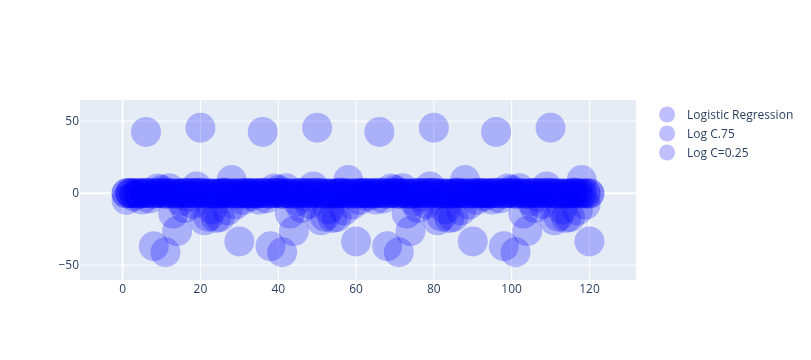

In [361]:
fig.add_scatter(x=dummyX,y=np.ravel(std_clf[1].coef_),name='Logistic Regression',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

fig.add_scatter(x=dummyX,y=np.ravel(std_clf_ridge75[1].coef_),name='Log C.75',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

fig.add_scatter(x=dummyX,y=np.ravel(std_clf_ridge25[1].coef_),name='Log C=0.25',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="iVijvP{JilL0x4[TJ0W5">fig</variable></variables><block type="varDoMethod" id="HQpV;xoS*)U_Y-rO#P{4" x="27" y="-371"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="[^*VvU=ur*$~r(uGX!~!"><field name="CODE">x=dummyX</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="Q,SRo.Q:3T{rp?o]*KWx"><field name="CODE">y=np.ravel(std_clf[1].coef_)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="Uo;}@W0{01M7FJGV%9BT"><field name="CODE">name='Logistic Regression'</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="6~35#1%UVEy[dWfSfBrD"><field name="CODE">mode='markers' </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="fy]h-y9~Ga=E`!ZU{VBc"><field name="CODE">marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block><block type="varDoMethod" id="0nc6)N;.]cO/8TUoc~Q;" x="32" y="-153"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="g81T9`mWQRxYOP[jBvD_"><field name="CODE">x=dummyX</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id=")WQs/Mq4DR-zc0J5r{dy"><field name="CODE">y=np.ravel(std_clf_ridge75[1].coef_)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="P-9lcG|Z!q!xWbQwC[RW"><field name="CODE">name='Log C.75'</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id=",~zD)nXs^On)Juos=b!:"><field name="CODE">mode='markers' </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="Fu?[cNFxT91].8tHfKP1"><field name="CODE">marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block><block type="varDoMethod" id="picr]6i3|Er9f)(H:(~5" x="38" y="46"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="Z%[P2Tk[1YA9Z|E+G6%u"><field name="CODE">x=dummyX</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="Ev|pg*)i-|^rU1)1gxiY"><field name="CODE">y=np.ravel(std_clf_ridge25[1].coef_)</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="NL~OQtcU$]:^%M^ukh-|"><field name="CODE">name='Log C=0.25'</field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="^`{,+}Eia.+x_iO7.r_i"><field name="CODE">mode='markers' </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="ft,bwGMp@BR|XXkqx=kF"><field name="CODE">marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block></xml>

To get a sense of the shrinkage, use the magnifying glass tool in `plotly` to zoom in until the y axis is about -2 to 2.
Then you can see that C=.25 penalty even more tightly shrunk that C=.75.

## Regression with a Lasso (L1) Penalty

In lasso regression, also known as L1 penalization, the cost function is altered by adding a penalty equivalent to the absolute value of the magnitude of the coefficients. This is equivalent to saying: for some $c > 0$, $|\beta_j| < 0$ for coefficients $\beta_j, j=1,\dots,p$. 

The cost function for lasso regression is

$$\sum_{i=1}^N (y_i-\hat{y_i})^2 = \sum_{i=1}^N (y_i - \sum_{j=0}^p \beta_i x_{ij})^2 + \lambda \sum_{j=0}^p |\beta_j|$$

When $\lambda = 0$, we have is a linear regression model.

The $\lambda$ regularizes the coefficients so the optimization function is penalized if the coefficients are large. This type of penalization leads to exactly zero coefficients. This feature of lasso regression shrinks the coefficients allowing for a reduction of model complexity and multicollinearity and allows use to perform feature selection.

### Model 4: Logistic lasso regression (C=.75)

Adding a lasso penalty is almost *exactly* like the model we did before.
There are three differences:

- penalty="l1"
- C = .75
- solver="liblinear"

The lasso penalty is an l1 penalty (because it's absolute value). 
The "solver" is the algorithm that implements the l1 penalty.

#### Training

- Set `std_clf_lasso75` to with `pipe` do `make_pipeline` using
    - with `pp` create `StandardScaler` using
    - with `linear_model` create `LogisticRegression` using
        - freestyle `penalty="l1"`
        - freestyle `C=0.75`
        - freestyle `solver="liblinear"`

In [362]:
std_clf_lasso75 = pipe.make_pipeline(pp.StandardScaler(),linear_model.LogisticRegression(penalty="l1",C=0.75,solver="liblinear"))

std_clf_lasso75

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="}81D/tZY#o}$E:M}:u4x" x="-20" y="-323"><field name="VAR" id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</field><value name="VALUE"><block type="varDoMethod" id="(Noh/e~gvTM3-4|;g]s["><mutation items="2"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">make_pipeline</field><data>pipe:make_pipeline</data><value name="ADD0"><block type="varCreateObject" id="x;`Wvk~k4yr[14`BAC)F"><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value><value name="ADD1"><block type="varCreateObject" id="_$Li7?^Mp?tnT4404jJ1"><mutation items="3"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="]:lQzM!Q2{*XVQ~+{^fL"><field name="CODE">penalty="l1"</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="s^i!mquS{XSAD${i!PTs"><field name="CODE"> C=0.75</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="u+G(FExS]csCr5QN1FDN"><field name="CODE">solver="liblinear"</field></block></value></block></value></block></value></block><block type="variables_get" id="ay[9h67;~5C(A3=iYkB6" x="322" y="-108"><field name="VAR" id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</field></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.75, penalty='l1', solver='liblinear'))])

We can treat the whole pipeline as a classifier and call `fit` on it:

-  with `std_clf_lasso75` do `fit` using
    - in list `splits` get # `1` (this is Xtrain)
    - with `np` do `ravel` using
        - in list `splits` get # `3` (this is Ytrain)

In [363]:
std_clf_lasso75.fit(splits[0],np.ravel(splits[2]))

std_clf_lasso75.score(splits[0],np.ravel(splits[2]))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="varDoMethod" id="Z)$q-zn.KTC{+^l-wH6u" x="58" y="-351"><mutation items="2"></mutation><field name="VAR" id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</field><field name="MEMBER">fit</field><data>std_clf_lasso75:fit</data><value name="ADD0"><block type="lists_getIndex" id="g`4[ONVs1(mZ1|PT-!%F"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="q?hSfY..(eq}W5zxd#wz"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="*dK_sT/qT$Fw(F=XOE*~"><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="pms|OSpwT3qaeW.%ao[*"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id="acG!G-0E(]!PpdA0aji6"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="At2{[Dm{ku3znhIni/cc"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="A0LvKoC!1n.??}]Kr;JU"><field name="NUM">3</field></block></value></block></value></block></value></block><block type="varDoMethod" id="!~,,9fRy$grnpt8AE;e{" x="71" y="-180"><mutation items="2"></mutation><field name="VAR" id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</field><field name="MEMBER">score</field><data>std_clf_lasso75:score</data><value name="ADD0"><block type="lists_getIndex" id="c8P0Gv#YQlprak^GPrFK"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="yY,T,Orx~RO3Ck+WoO-f"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="db*ptyYOCT?nl3IukSh("><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="?X|NXI!JXJi^34}d12zk"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id=",bfesGvHC%V:~{IT|C,="><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="O0}/4-[]y1{r^]P+:qAu"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="gHdE97Tk9^@ysLs9i5g_"><field name="NUM">3</field></block></value></block></value></block></value></block></xml>

0.9906103286384976

Now we can get predictions from the model for our test data:

- Set `predictions_lasso75` to with `std_clf_lasso75` do `predict` using
    - in list `splits` get # `2` (this is Xtest)

In [364]:
predictions_lasso75 = std_clf_lasso75.predict(splits[1])

predictions_lasso75

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</variable><variable id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="variables_set" id="NHw$/HH988vNLbZgn)CM" x="15" y="-166"><field name="VAR" id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</field><value name="VALUE"><block type="varDoMethod" id="N}3ds6:i%0MtTA:(2im4"><mutation items="1"></mutation><field name="VAR" id="q1J}F(vBK]9@{^K9+Yni">std_clf_lasso75</field><field name="MEMBER">predict</field><data>std_clf_lasso75:predict</data><value name="ADD0"><block type="lists_getIndex" id="}F:t#{8N+nqe+mq+l!hO"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="2mJ1b`_i661WvtJ3vYil"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="YIcJ18^v]Wli^=P2Ofk/"><field name="NUM">2</field></block></value></block></value></block></value></block><block type="variables_get" id="zY;Fo:gcP~^aB(BXf_ad" x="152" y="-84"><field name="VAR" id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</field></block></xml>

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluation

To get the accuracy:

- `print` `create text with`
    - "Accuracy:"
    - with `metrics` do `accuracy_score` using
        - in list `splits` get # `4`  (this is `Ytest`)
        - `predictions_lasso75`

In [365]:
print('Accuracy:' + str(metrics.accuracy_score(splits[3],predictions_lasso75)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="6KCf/4(JectOv*aO[L6d" x="46" y="41"><value name="TEXT"><block type="text_join" id="|l|?2Yb#{m=ys_V^)+v-"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="8MdDU0D^rCAqKltb#kaY"><field name="TEXT">Accuracy:</field></block></value><value name="ADD1"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="lists_getIndex" id="%c.A6Q(aG[*#*job/j`h"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="YVopjZLjvJM^9Y3261E|"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="Ys#,f#Li+$`ovMl;TUGl"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="VrfB)jj3nIE=o$B!ZD3("><field name="VAR" id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</field></block></value></block></value></block></value></block></xml>

Accuracy:0.965034965034965


To get precision, recall, and F1:

- `print` with `metrics` do `classification_report` using
    - in list `splits` get # `4`  (this is `Ytest`)
    - `predictions_lasso75`

In [366]:
print(metrics.classification_report(splits[3],predictions_lasso75))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="w?Z]Mpw]G,uTA;S:C5Ef" x="0" y="0"><value name="TEXT"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="lists_getIndex" id="%c.A6Q(aG[*#*job/j`h"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="YVopjZLjvJM^9Y3261E|"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="Ys#,f#Li+$`ovMl;TUGl"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="$/FZ8^lP/slN(#TGKv4`"><field name="VAR" id="+c@nB4b@*dAXK60P0,vq">predictions_lasso75</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        56
           1       0.98      0.97      0.97        87

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143



Interestingly, model 4 is the same as model 2. Both are .965 accuracy and .97 weighted average f1.

### Model 5: Logistic lasso regression (C=.25)

This model is the same as model 4 but with a different ridge penalty:

- penalty="l1"
- C = .25
- solver="liblinear"

#### Training

- Set `std_clf_lasso25` to with `pipe` do `make_pipeline using`
    - with `pp` create `StandardScaler` using
    - with `linear_model` create `LogisticRegression` using
        - freestyle `penalty="l1"`
        - freestyle `C=0.25`
        - freestyle `solver="liblinear"`

In [367]:
std_clf_lasso25 = pipe.make_pipeline(pp.StandardScaler(),linear_model.LogisticRegression(penalty="l1",C=0.25,solver="liblinear"))

std_clf_lasso25

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</variable><variable id="=z9KfSBWpoDS,oj-?yx,">pipe</variable><variable id=".T`xqZHAu7r0$MQ4s=Yg">pp</variable><variable id="cGnMvhq5543q[r$:Og-x">linear_model</variable></variables><block type="variables_set" id="}81D/tZY#o}$E:M}:u4x" x="39" y="-196"><field name="VAR" id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</field><value name="VALUE"><block type="varDoMethod" id="(Noh/e~gvTM3-4|;g]s["><mutation items="2"></mutation><field name="VAR" id="=z9KfSBWpoDS,oj-?yx,">pipe</field><field name="MEMBER">make_pipeline</field><data>pipe:make_pipeline</data><value name="ADD0"><block type="varCreateObject" id="*y-DOhy*0eK!y=jlX%Vq"><mutation items="1"></mutation><field name="VAR" id=".T`xqZHAu7r0$MQ4s=Yg">pp</field><field name="MEMBER">StandardScaler</field><data>pp:StandardScaler</data></block></value><value name="ADD1"><block type="varCreateObject" id="L/zHUB;*RA0rpNB#EiOq"><mutation items="3"></mutation><field name="VAR" id="cGnMvhq5543q[r$:Og-x">linear_model</field><field name="MEMBER">LogisticRegression</field><data>linear_model:LogisticRegression</data><value name="ADD0"><block type="dummyOutputCodeBlock" id=";)R5hUm]uIoCD$F}l|OZ"><field name="CODE">penalty="l1"</field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="~Lvks:7zXaf|6Y6_|5=B"><field name="CODE">C=0.25</field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="VQaD:.k!}b2Dyu2s0^VG"><field name="CODE">solver="liblinear"</field></block></value></block></value></block></value></block><block type="variables_get" id="@f$%zMi=|0B5PHMY~7tL" x="405" y="21"><field name="VAR" id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</field></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.25, penalty='l1', solver='liblinear'))])

We can treat the whole pipeline as a classifier and call `fit` on it:

-  with `std_clf_lasso25` do `fit` using
    - in list `splits` get # `1` (this is Xtrain)
    - with `np` do `ravel` using
        - in list `splits` get # `3` (this is Ytrain)

In [368]:
std_clf_lasso25.fit(splits[0],np.ravel(splits[2]))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</variable><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="varDoMethod" id="Z)$q-zn.KTC{+^l-wH6u" x="0" y="0"><mutation items="2"></mutation><field name="VAR" id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</field><field name="MEMBER">fit</field><data>std_clf_lasso25:fit</data><value name="ADD0"><block type="lists_getIndex" id="|0={JEWA:Sp3FpK+8D)k"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="eVY-ZMOIB25{d!RcF`;l"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="#QPh|=KOaa]%$3Ttj_zE"><field name="NUM">1</field></block></value></block></value><value name="ADD1"><block type="varDoMethod" id="f!j5/*agq?zgIeBG[Lw2"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">ravel</field><data>np:ravel</data><value name="ADD0"><block type="lists_getIndex" id="6V{|*mRLBt6VflE@*~Os"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="%fMhWUtsUBp[czd^A`)o"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="kl-8hK[r#:I=Q8,4WtZ1"><field name="NUM">3</field></block></value></block></value></block></value></block></xml>

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.25, penalty='l1', solver='liblinear'))])

Now we can get predictions from the model for our test data:

- Set `predictions_lasso25` to with `std_clf_lasso25` do `predict` using
    - in list `splits` get # `2` (this is Xtest)

In [369]:
predictions_lasso25 = std_clf_lasso25.predict(splits[1])

predictions_lasso25

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</variable><variable id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="variables_set" id="NHw$/HH988vNLbZgn)CM" x="0" y="0"><field name="VAR" id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</field><value name="VALUE"><block type="varDoMethod" id="N}3ds6:i%0MtTA:(2im4"><mutation items="1"></mutation><field name="VAR" id="3,Px5LeEX8#KHZdo}cMj">std_clf_lasso25</field><field name="MEMBER">predict</field><data>std_clf_lasso25:predict</data><value name="ADD0"><block type="lists_getIndex" id="|0={JEWA:Sp3FpK+8D)k"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="eVY-ZMOIB25{d!RcF`;l"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="#QPh|=KOaa]%$3Ttj_zE"><field name="NUM">2</field></block></value></block></value></block></value></block><block type="variables_get" id="fKh4vW%C*2]/rqWB$0{W" x="74" y="85"><field name="VAR" id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</field></block></xml>

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

#### Evaluation

To get the accuracy:

- `print` `create text with`
    - "Accuracy:"
    - with `metrics` do `accuracy_score` using
        - in list `splits` get # `4`  (this is `Ytest`)
        - `predictions_lasso25`

In [370]:
print('Accuracy:' + str(metrics.accuracy_score(splits[3],predictions_lasso25)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="6KCf/4(JectOv*aO[L6d" x="0" y="0"><value name="TEXT"><block type="text_join" id="|l|?2Yb#{m=ys_V^)+v-"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="8MdDU0D^rCAqKltb#kaY"><field name="TEXT">Accuracy:</field></block></value><value name="ADD1"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">accuracy_score</field><data>metrics:accuracy_score</data><value name="ADD0"><block type="lists_getIndex" id="|0={JEWA:Sp3FpK+8D)k"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="eVY-ZMOIB25{d!RcF`;l"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="#QPh|=KOaa]%$3Ttj_zE"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="rg#1UUMe)Xz1hU!_X2,6"><field name="VAR" id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</field></block></value></block></value></block></value></block></xml>

Accuracy:0.9790209790209791


To get precision, recall, and F1:

- `print` with `metrics` do `classification_report` using
    - in list `splits` get # `4`  (this is `Ytest`)
    - `predictions_lasso25`

In [371]:
print(metrics.classification_report(splits[3],predictions_lasso25))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id=")}+w@N9iB/j=:+PLkMv8">metrics</variable><variable id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</variable><variable id="_ut$e0PL4OMi4o1MXTpw">splits</variable></variables><block type="text_print" id="w?Z]Mpw]G,uTA;S:C5Ef" x="0" y="0"><value name="TEXT"><block type="varDoMethod" id="p`ehX8lLN?zayQ1Ip=}V"><mutation items="2"></mutation><field name="VAR" id=")}+w@N9iB/j=:+PLkMv8">metrics</field><field name="MEMBER">classification_report</field><data>metrics:classification_report</data><value name="ADD0"><block type="lists_getIndex" id="|0={JEWA:Sp3FpK+8D)k"><mutation statement="false" at="true"></mutation><field name="MODE">GET</field><field name="WHERE">FROM_START</field><value name="VALUE"><block type="variables_get" id="eVY-ZMOIB25{d!RcF`;l"><field name="VAR" id="_ut$e0PL4OMi4o1MXTpw">splits</field></block></value><value name="AT"><block type="math_number" id="#QPh|=KOaa]%$3Ttj_zE"><field name="NUM">4</field></block></value></block></value><value name="ADD1"><block type="variables_get" id="[63A25B|4miQmdCS4wVL"><field name="VAR" id="HnF212Y;k[w3}`%f{M`b">predictions_lasso25</field></block></value></block></value></block></xml>

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.98      0.99      0.98        87

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



Model 5 (accuracy .979 and weighted avg f1 .98) is slightly better than model 3 (.972 accuracy and .97 weighted average f1).
Additionally, lasso has done something that ridge didn't do: it has shrunk many coefficients to zero.
So it's actually pretty amazing that lasso is slightly better than ridge after so many variables have been removed.
To see which ones, run the cell below:

In [372]:
m5coefficients = pd.DataFrame( {"variable":X.columns, "coefficient":np.ravel(std_clf_lasso25[1].coef_) })
print(m5coefficients.to_string())
print( 'Variables removed (zero coefficient):' , len( m5coefficients[m5coefficients['coefficient']==0.0] ) )

                        variable  coefficient
0                  mean radius_0     0.000000
1                 mean texture_1     0.000000
2               mean perimeter_2     0.000000
3                    mean area_3     0.000000
4              mean smoothness_4     0.000000
5             mean compactness_5     0.000000
6               mean concavity_6    -0.064739
7          mean concave points_7    -0.044354
8                mean symmetry_8     0.000000
9       mean fractal dimension_9     0.000000
10               radius error_10    -0.019905
11              texture error_11     0.000000
12            perimeter error_12     0.000000
13                 area error_13     0.000000
14           smoothness error_14     0.000000
15          compactness error_15     0.000000
16            concavity error_16     0.000000
17       concave points error_17     0.000000
18             symmetry error_18     0.000000
19    fractal dimension error_19     0.000000
20               worst radius_20  

We started with 120 and zeroed out 84. 
Obviously many of the variables remaining are duplicates; handling these is a more complex topic!

### Comparing Lasso models

As before, let's plot the coefficients of models 1, 4, and 5 to show the effect of the lasso penalty on the coefficients.

Create an empty figure:

- Set `fig` to with `go` create `Figure` using

In [373]:
fig = go.Figure()

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="iVijvP{JilL0x4[TJ0W5">fig</variable><variable id="OKcExL8S^d~/xPz+HHW]">go</variable></variables><block type="variables_set" id="JP@qBQ@:}E,t2^D1PKJX" x="-9" y="-167"><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><value name="VALUE"><block type="varCreateObject" id="QX%dqV[hk4VGdxlZ@i.`"><mutation items="1"></mutation><field name="VAR" id="OKcExL8S^d~/xPz+HHW]">go</field><field name="MEMBER">Figure</field><data>go:Figure</data></block></value></block></xml>

Add three scatterplots to `fig`:

- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf[1].coef_)`
    - freestyle `name='Logistic Regression'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='blue', opacity=0.25, size=30)`
    
**For the next two, copy the first and make small changes.**

- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf_lasso75[1].coef_)`
    - freestyle `name='Logistic Lasso Regression C=.75'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='green', opacity=0.50, size=15)`
    
    
- with `fig` do `add_scatter` using
    - freestyle `x=dummyX`
    - freestyle `y=np.ravel(std_clf_lasso25[1].coef_)`
    - freestyle `name='Logistic Lasso Regression C=.25'`
    - freestyle `mode='markers'`
    - freestyle `marker=dict(color='red', opacity=0.75, size=8)`

In [374]:
fig.add_scatter(x=dummyX,y=np.ravel(std_clf[1].coef_),name='Logistic Regression',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

fig.add_scatter(x=dummyX,y=np.ravel(std_clf_lasso75[1].coef_),name='Logistic C.75',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

fig.add_scatter(x=dummyX,y=np.ravel(std_clf_lasso25[1].coef_),name='Logistic C=0.25',mode='markers',marker=dict(color='blue', opacity=0.25, size=30))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="iVijvP{JilL0x4[TJ0W5">fig</variable></variables><block type="varDoMethod" id="HQpV;xoS*)U_Y-rO#P{4" x="0" y="0"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="7]Y(SNh.4$Hcp3~T)!~]"><field name="CODE">x=dummyX  </field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="R.o5~dj`r4-Dc^sRo=/="><field name="CODE">y=np.ravel(std_clf[1].coef_) </field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="#iT3*[{-K{lbGCV@!3U."><field name="CODE">name='Logistic Regression' </field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="TTNDKFFUt,13}cH*q){:"><field name="CODE">mode='markers'  </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="A(QBq}@R!+QnHdF}fQ3,"><field name="CODE"> marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block><block type="varDoMethod" id=",X-!^he;F^@hyO.qM?AH" x="-22" y="199"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="wM:B5XMHq1ZMNPM.F;t}"><field name="CODE">x=dummyX  </field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="Ruq4#;Q,Fc;A*_F9P~gP"><field name="CODE">y=np.ravel(std_clf_lasso75[1].coef_) </field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id="G)!d_z2`AX!.,VjtZnlB"><field name="CODE">name='Logistic C.75' </field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="Ko25?de;*fJdKf,E[4RA"><field name="CODE">mode='markers'  </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="w$Sr[c~WbwFRA^7v={XM"><field name="CODE"> marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block><block type="varDoMethod" id="7$;s4B)_/D24^KK{POhu" x="-20" y="411"><mutation items="5"></mutation><field name="VAR" id="iVijvP{JilL0x4[TJ0W5">fig</field><field name="MEMBER">add_scatter</field><data>fig:add_scatter</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="*mfQI.5w4`fvN5q9bB4U"><field name="CODE">x=dummyX  </field></block></value><value name="ADD1"><block type="dummyOutputCodeBlock" id="%J.:MsAf*1i1xoTHaB-!"><field name="CODE">y=np.ravel(std_clf_lasso25[1].coef_) </field></block></value><value name="ADD2"><block type="dummyOutputCodeBlock" id=",r65AiS]QXn5:RO8pY@z"><field name="CODE">name='Logistic C=0.25' </field></block></value><value name="ADD3"><block type="dummyOutputCodeBlock" id="}TrPXn~LgOFJIk^LCDTM"><field name="CODE">mode='markers'  </field></block></value><value name="ADD4"><block type="dummyOutputCodeBlock" id="iJ?[,jubJbS?Px*vR?{I"><field name="CODE"> marker=dict(color='blue', opacity=0.25, size=30)</field></block></value></block></xml>

Again, us the magnifying glass tool in `plotly` to zoom in until the y axis is about -1 to 1, and notice how many coefficients are zero for C=.75 and C=.25.

We can count how many are zero in each case as well:

- `print` `create text with`
    - `"C=.75:"`
    - with `np` do `sum` using
        - freestyle `std_clf_lasso75[1].coef_` = `0`
- `print` `create text with`
    - `"C=.25:"`
    - with `np` do `sum` using
        -  freestyle `std_clf_lasso25[1].coef_` = `0`

In [375]:
print('C=.75:' + str(np.sum(std_clf_lasso75[1].coef_)))
print('C=.75:' + str(np.sum(std_clf_lasso25[1].coef_)))

#<xml xmlns="https://developers.google.com/blockly/xml"><variables><variable id="Zhzp)s*VL?V@ES3(j:*b">np</variable></variables><block type="text_print" id="/TJ/VZlki.*U:sn%Qq6L" x="-196" y="120"><value name="TEXT"><block type="text_join" id="sHD%SD!~zSv7#r#2uYxt"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="q5J(xhjihG5-FX67f]J/"><field name="TEXT">C=.75:</field></block></value><value name="ADD1"><block type="varDoMethod" id="LjAKu^y%{rV~l|z,S8YK"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">sum</field><data>np:sum</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="%5aroOmWLB^|Gh;/J,B;"><field name="CODE">std_clf_lasso75[1].coef_ </field></block></value></block></value></block></value><next><block type="text_print" id="AGl;z/x1_Hyb%=cSdNQz"><value name="TEXT"><block type="text_join" id="~)p9oL`yYEqZQ^Fvs:1o"><mutation items="2"></mutation><value name="ADD0"><block type="text" id="}+fzcX:^u4a#i3BlV7OI"><field name="TEXT">C=.75:</field></block></value><value name="ADD1"><block type="varDoMethod" id="#l/?AjG(;@z3IgJ]swGB"><mutation items="1"></mutation><field name="VAR" id="Zhzp)s*VL?V@ES3(j:*b">np</field><field name="MEMBER">sum</field><data>np:sum</data><value name="ADD0"><block type="dummyOutputCodeBlock" id="?8m5o6;=Py$U4pE8n-LY"><field name="CODE">std_clf_lasso25[1].coef_ </field></block></value></block></value></block></value></block></next></block></xml>

C=.75:-11.043373054702172
C=.75:-7.397283144153425


Even a small amount of penalization, in this case, removed a lot of variables.
Lasso is a great way to simplify your model!

## Choosing $\lambda$ (AKA C)

As we've seen, different values of the penalty parameter $\lambda$ have different effects on our accuracy and other performance metrics.
So how do we choose  $\lambda$?
There are a number of different methods of finding a **metaparameter** like  $\lambda$, and these methods are fairly general and apply to other problems we've seen before, like choosing the optimal number of clusters or the optimal number of nearest neighbors.
We will revisit this idea in the future. 

## Check your knowledge

**Hover to see the correct answer.**

1.  What is the primary purpose of **regularization** in machine learning models?
- To increase model complexity and improve fitting to training data.
- To speed up the training process of the model.
- <div title="Correct answer"> To penalize complex models in favor of simpler ones, helping to prevent overfitting.</div>
- To add more predictor variables to the model.



2.  Which of the following problems does **regularization** specifically help to mitigate in regression models with a large number of predictors?
- Underfitting
- <div title="Correct answer">Multicollinearity</div>
- Bias-variance trade-off in the direction of high bias
- Data imbalance



3.  In the context of Ridge Regression (L2 penalization), what does the $\lambda$ (lambda) parameter control?
- The number of features selected by the model.
- <div title="Correct answer">The strength of the penalty applied to the square of the coefficients.</div>
- The learning rate of the optimization algorithm.
- The intercept of the regression line.



4.  How does a **Ridge (L2) penalty** affect the coefficients of a regression model?
- It sets some coefficients exactly to zero, performing feature selection.
- <div title="Correct answer">It shrinks the coefficients towards zero but rarely makes them exactly zero.</div>
- It increases the magnitude of the coefficients, leading to a more complex model.
- It has no effect on the coefficients; it only affects the intercept.



5.  What is a key difference between **Ridge (L2) Regression** and **Lasso (L1) Regression**?
- Ridge Regression is used for classification, while Lasso Regression is for regression.
- <div title="Correct answer">Lasso Regression can set coefficients exactly to zero, effectively performing feature selection, while Ridge Regression shrinks them towards zero but keeps them.</div>
- Ridge Regression uses the absolute value of coefficients for penalty, while Lasso uses the squared value.
- Lasso Regression is computationally less intensive than Ridge Regression.



<!--  -->